## Chicago Chain Runs
#### Wards of Magnitude 4 (12) out of Community Areas

This notebook performs the following chain run:
- Out of community areas:
    - However many districts that have magnitude 4: 12
    - Population = 4 * pop/50
    - Uses Metropolis-Hastings for acceptance
        - Approximating function:
            - Dev(ith alderman) = pop of their ward / ideal of ward - 1
            - Dev_plan = sum of the squares of the above
            - Gibbs distribution = P(part plan) \prop e^(-Dev(plan))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from functools import partial
import pickle
import math
import random

import gerrychain as gc
from gerrychain.updaters import Tally, cut_edges
import gerrychain.tree_proposals as tp
from gerrychain import accept

In [2]:
# Increase the recursion depth
sys.setrecursionlimit(15000)

In [3]:
# Create the graph
# comareas = gc.Graph.from_file("./shapefiles/chicago_community_areas.shp")
precincts = gc.Graph.from_file("./shapefiles/chicago_precincts_2012.shp")
comareas = precincts

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1237, 2068), (1249, 2068), (1240, 2068)}
  overlaps


In [4]:
# Create an initial plan that does not violate population constraints
num_partitions = 50 // 4
pop_col = "TOTPOP"
pop_target = sum(comareas.nodes[node][pop_col] for node in comareas) / num_partitions

assignment = tp.recursive_tree_part(
    comareas,
    parts=range(num_partitions),
    pop_target=pop_target,
    pop_col=pop_col,
    epsilon=0.05
)

In [5]:
# Create an election object and updaters
election = gc.Election("M15", ["Emanuel_M1", "Wilson_M15", "Fioretti_M", "Garcia_M15", "Walls_M15"])
updaters = {"population": gc.updaters.Tally("TOTPOP", alias="population"), "M15": election, "cut_edges": gc.updaters.cut_edges}

# Create an initial partition
initial = gc.GeographicPartition(
    precincts,
    assignment=assignment,
    updaters=updaters)

In [16]:
# Configure the ReCom proposal and constraints
proposal_4 = partial(tp.recom,
                      pop_col=pop_col,
                      pop_target=pop_target,
                      epsilon=0.05,
                      node_repeats=10)

compactness_bound = gc.constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2 * len(initial["cut_edges"]))

In [17]:
def metropolis_hastings(state, ideal_pop):
    """
    Metropolis-Hastings Algorithm for state acceptance.
    It explores the space ~25% of the time.
    
    state (Markov chain state): The proposed next state
    ideal_pop (float): The ideal population of a district
    return: bool for acceptance
    """
    all_deviation = []
    for ward, pop in state["population"].items():
        all_deviation.append(((pop / ideal_pop) - 1) ** 2)
    plan_deviation = sum(all_deviation)
    acceptance_prob = 0.75 * math.exp(-plan_deviation)
    return (random.random() < acceptance_prob)

In [18]:
# Configure Metropolis-Hastings
met_hastings = partial(metropolis_hastings, ideal_pop=pop_target)

In [19]:
# Configure the Markov Chain
comareas_chain4 = gc.MarkovChain(
    proposal=proposal_4,
    constraints=[compactness_bound],
    accept=met_hastings,
    initial_state=initial,
    total_steps=100)

In [21]:
# Run the 50 ward chain
chain4_results = {"Emanuel_M1": [],
                   "Wilson_M15": [],
                   "Fioretti_M": [],
                   "Garcia_M15": [],
                   "Walls_M15": []}

for partition in comareas_chain4:
    for key, _ in chain4_results.items():
        chain4_results[key].append(sorted(partition["M15"].percents(key)))

In [22]:
# Create the DataFrames from the results
chain4_dfs = {"Emanuel_M1": [],
               "Wilson_M15": [],
               "Fioretti_M": [],
               "Garcia_M15": [],
               "Walls_M15": []}

for key, val in chain4_results.items():
    chain4_dfs[key] = pd.DataFrame(val)

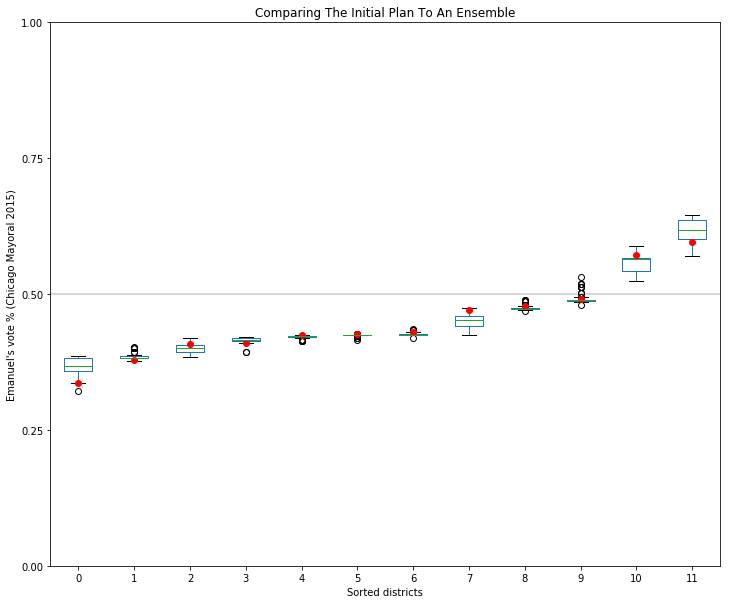

In [23]:
# Results visualized for Emanuel
data = chain4_dfs["Emanuel_M1"]
fig, ax = plt.subplots(figsize=(12, 10))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
data.iloc[0].plot(style="ro", ax=ax)

# Annotate
ax.set_title("Comparing The Initial Plan To An Ensemble")
ax.set_ylabel("Emanuel's vote % (Chicago Mayoral 2015)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

In [24]:
# Store the dictionary of results for later
with open("run_results/comareas4_results", "ab") as file:
    pickle.dump(chain4_dfs, file)